In [1]:
from kuramoto.nmf import *
from kuramoto.SDL_BCD import SDL_BCD

In [2]:
sampling_alg = 'pivot'

ntwk = 'UCLA26' # COVID_PPI, Wisconsin87, Caltech36, UCLA26
ntwk_nonumber = ''.join([i for i in ntwk if not i.isdigit()])
save_folder = 'images/'
k = 50

path = "../Data/Networks_all_NDL/" + str(ntwk) + '.txt'
G = nn.NNetwork()
G.load_add_edges(path, increment_weights=False, use_genfromtxt=True)
print('num nodes in G', len(G.nodes()))
print('num edges in G', len(G.get_edges()))

num nodes in G 20467
num edges in G 1495226


num of subgraphs induced on k-paths: 2500
X.shape (2500, 2500)


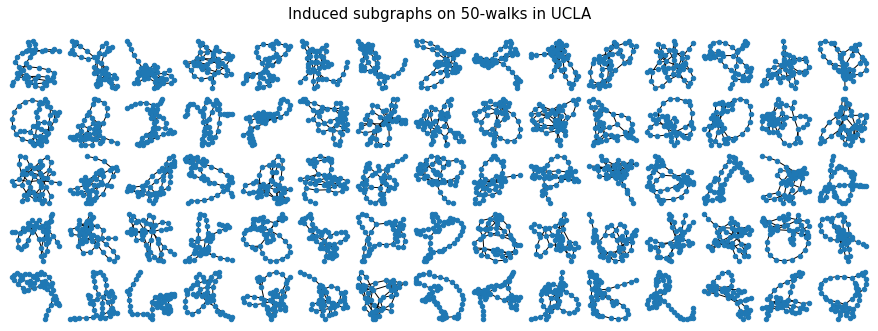

In [3]:
X, embs = G.get_patches(k=k, sample_size=2500, skip_folded_hom=True)

display_graphs(title='Induced subgraphs on {}-walks in {}'.format(k, ntwk_nonumber),
                 save_path=save_folder + ntwk_nonumber + "_subgraphs_"+ str(sampling_alg) + "_walk", 
                 data = [X, embs],
                 grid_shape = [5, 15],
                 fig_size = [15, 5],
                 show_importance=False)

In [4]:
graph_list = generate_nxg(X)
print(f"num of graphs: {len(graph_list)}")

num of graphs: 2500


In [5]:
nodes = int(np.sqrt(X.shape[0]))
df = pd.DataFrame()
K = 5

for G in graph_list:
        
    if nx.is_connected(G):

        adj_mat = nx.to_numpy_array(G)
        temp = pd.DataFrame(np.array(nx.adjacency_matrix(G).todense().flatten('C')))
        
        model = Kuramoto(coupling=K, dt=0.01, T=18, n_nodes=nodes, half_sync=False)

        sim = model.run(adj_mat)
        arr = sim.T[-1]
        conc = pd.DataFrame(pd.Series(synchronization(arr)), columns=['Synchronized'])
            
        temp = pd.concat([temp, conc], axis=1)

        df = pd.concat([df, temp], ignore_index=True)
    
df

,0,1,2,3,4,5,6,7,8,9,...,2491,2492,2493,2494,2495,2496,2497,2498,2499,Synchronized
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
3,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
4,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2496,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,False
2497,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,False
2498,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,True


In [6]:
print(f"% of synchronized cases: {sum(df['Synchronized'])/len(df)}")

% of synchronized cases: 0.2596


In [7]:
X_true = df[df['Synchronized'] == True].drop(['Synchronized'], axis=1).values.astype('float32').T
X_false = df[df['Synchronized'] == False].drop(['Synchronized'], axis=1).values.astype('float32').T

In [8]:
W_true, H_true = ALS(X = X_true, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_true: {W_true.shape}\n###########################\n\n")

W_false, H_false = ALS(X = X_false, 
           n_components = 16, # Reconstruction Error reduces as n_components increases
           n_iter = 1000, 
           a0 = 0, # L1 regularizer for H
           a1 = 0, # L1 regularizer for W
           a12 = 0, # L2 regularizer for W
           H_nonnegativity = True,
           W_nonnegativity = True,
           compute_recons_error = True,
           subsample_ratio = 1)

print(f"\n\n###########################\nShape of W_false: {W_false.shape}\n###########################\n\n")

  1%|▎                                         | 7/1000 [00:00<00:15, 63.03it/s]

iteration 0, reconstruction error 109687.193670
iteration 10, reconstruction error 47185.439189


  2%|▊                                        | 21/1000 [00:00<00:16, 60.24it/s]

iteration 20, reconstruction error 48214.564724


  3%|█▏                                       | 28/1000 [00:00<00:15, 60.76it/s]

iteration 30, reconstruction error 50001.834015


  4%|█▋                                       | 42/1000 [00:00<00:15, 61.57it/s]

iteration 40, reconstruction error 50458.842425


  5%|██                                       | 49/1000 [00:00<00:15, 63.05it/s]

iteration 50, reconstruction error 50383.372224


  6%|██▌                                      | 63/1000 [00:01<00:15, 62.35it/s]

iteration 60, reconstruction error 50061.913828


  7%|██▊                                      | 70/1000 [00:01<00:15, 61.58it/s]

iteration 70, reconstruction error 49177.700876


  8%|███▍                                     | 84/1000 [00:01<00:14, 64.08it/s]

iteration 80, reconstruction error 47123.684368


  9%|███▋                                     | 91/1000 [00:01<00:13, 65.00it/s]

iteration 90, reconstruction error 43810.721953


 10%|████                                     | 98/1000 [00:01<00:13, 65.11it/s]

iteration 100, reconstruction error 41744.747609


 11%|████▍                                   | 112/1000 [00:01<00:13, 64.33it/s]

iteration 110, reconstruction error 41105.429748


 12%|████▊                                   | 119/1000 [00:01<00:13, 63.67it/s]

iteration 120, reconstruction error 40647.174024


 13%|█████▎                                  | 133/1000 [00:02<00:13, 64.79it/s]

iteration 130, reconstruction error 40292.658954


 14%|█████▌                                  | 140/1000 [00:02<00:13, 65.19it/s]

iteration 140, reconstruction error 40023.809817


 15%|██████▏                                 | 154/1000 [00:02<00:13, 64.70it/s]

iteration 150, reconstruction error 39818.390569


 16%|██████▍                                 | 161/1000 [00:02<00:12, 65.29it/s]

iteration 160, reconstruction error 39657.610164


 17%|██████▋                                 | 168/1000 [00:02<00:13, 63.37it/s]

iteration 170, reconstruction error 39528.944060


 18%|███████▎                                | 182/1000 [00:02<00:12, 62.95it/s]

iteration 180, reconstruction error 39424.879319


 19%|███████▌                                | 190/1000 [00:02<00:12, 65.48it/s]

iteration 190, reconstruction error 39338.627774


 20%|████████▏                               | 204/1000 [00:03<00:12, 65.91it/s]

iteration 200, reconstruction error 39265.624420


 21%|████████▍                               | 211/1000 [00:03<00:12, 64.43it/s]

iteration 210, reconstruction error 39202.631994


 22%|████████▋                               | 218/1000 [00:03<00:11, 65.75it/s]

iteration 220, reconstruction error 39147.508065


 23%|█████████▎                              | 232/1000 [00:03<00:11, 64.35it/s]

iteration 230, reconstruction error 39098.636932


 24%|█████████▌                              | 239/1000 [00:03<00:11, 64.93it/s]

iteration 240, reconstruction error 39054.744728


 25%|██████████▏                             | 254/1000 [00:03<00:11, 66.25it/s]

iteration 250, reconstruction error 39014.933512


 26%|██████████▍                             | 261/1000 [00:04<00:11, 65.07it/s]

iteration 260, reconstruction error 38978.517872


 27%|██████████▋                             | 268/1000 [00:04<00:11, 65.76it/s]

iteration 270, reconstruction error 38945.007138


 28%|███████████▎                            | 282/1000 [00:04<00:10, 66.13it/s]

iteration 280, reconstruction error 38914.012315


 29%|███████████▌                            | 289/1000 [00:04<00:10, 65.05it/s]

iteration 290, reconstruction error 38885.366390


 30%|████████████                            | 303/1000 [00:04<00:10, 65.60it/s]

iteration 300, reconstruction error 38858.993510


 31%|████████████▍                           | 311/1000 [00:04<00:10, 65.79it/s]

iteration 310, reconstruction error 38834.659241


 32%|████████████▋                           | 318/1000 [00:04<00:10, 64.10it/s]

iteration 320, reconstruction error 38812.295072


 34%|█████████████▋                          | 341/1000 [00:05<00:12, 53.56it/s]

iteration 330, reconstruction error 38791.722687
iteration 340, reconstruction error 38772.894894


 37%|██████████████▋                         | 367/1000 [00:05<00:09, 69.35it/s]

iteration 350, reconstruction error 38755.715026
iteration 360, reconstruction error 38740.015347


 38%|███████████████▍                        | 385/1000 [00:05<00:08, 75.65it/s]

iteration 370, reconstruction error 38725.675500
iteration 380, reconstruction error 38712.641027


 40%|████████████████                        | 403/1000 [00:06<00:07, 79.91it/s]

iteration 390, reconstruction error 38700.772521
iteration 400, reconstruction error 38689.920694


 42%|████████████████▊                       | 421/1000 [00:06<00:07, 82.23it/s]

iteration 410, reconstruction error 38679.992737
iteration 420, reconstruction error 38670.898220


 44%|█████████████████▌                      | 439/1000 [00:06<00:06, 82.34it/s]

iteration 430, reconstruction error 38662.535707
iteration 440, reconstruction error 38654.874131


 46%|██████████████████▌                     | 465/1000 [00:07<00:08, 64.00it/s]

iteration 450, reconstruction error 38647.809261
iteration 460, reconstruction error 38641.285451


 48%|███████████████████▎                    | 483/1000 [00:07<00:07, 72.55it/s]

iteration 470, reconstruction error 38635.267250
iteration 480, reconstruction error 38629.703453


 50%|███████████████████▉                    | 498/1000 [00:07<00:09, 53.71it/s]

iteration 490, reconstruction error 38624.557373
iteration 500, reconstruction error 38619.780709


 52%|████████████████████▉                   | 523/1000 [00:08<00:07, 63.37it/s]

iteration 510, reconstruction error 38615.337958
iteration 520, reconstruction error 38611.206130


 54%|█████████████████████▋                  | 541/1000 [00:08<00:06, 73.94it/s]

iteration 530, reconstruction error 38607.340288
iteration 540, reconstruction error 38603.726449


 57%|██████████████████████▋                 | 568/1000 [00:08<00:05, 80.46it/s]

iteration 550, reconstruction error 38600.326038
iteration 560, reconstruction error 38597.102181


 59%|███████████████████████▍                | 586/1000 [00:08<00:05, 82.36it/s]

iteration 570, reconstruction error 38594.051390
iteration 580, reconstruction error 38591.150882


 60%|████████████████████████▏               | 604/1000 [00:09<00:04, 83.91it/s]

iteration 590, reconstruction error 38588.376926
iteration 600, reconstruction error 38585.720353


 62%|████████████████████████▉               | 622/1000 [00:09<00:04, 83.55it/s]

iteration 610, reconstruction error 38583.168065
iteration 620, reconstruction error 38580.706702


 64%|█████████████████████████▌              | 640/1000 [00:09<00:04, 74.35it/s]

iteration 630, reconstruction error 38578.332472
iteration 640, reconstruction error 38576.034627


 67%|██████████████████████████▋             | 667/1000 [00:09<00:04, 80.09it/s]

iteration 650, reconstruction error 38573.812763
iteration 660, reconstruction error 38571.652523


 68%|███████████████████████████▍            | 685/1000 [00:10<00:03, 82.16it/s]

iteration 670, reconstruction error 38569.546202
iteration 680, reconstruction error 38567.490758


 70%|████████████████████████████            | 703/1000 [00:10<00:03, 83.03it/s]

iteration 690, reconstruction error 38565.479644
iteration 700, reconstruction error 38563.509939


 72%|████████████████████████████▊           | 721/1000 [00:10<00:03, 82.85it/s]

iteration 710, reconstruction error 38561.582154
iteration 720, reconstruction error 38559.691035


 75%|█████████████████████████████▉          | 748/1000 [00:10<00:03, 82.78it/s]

iteration 730, reconstruction error 38557.835001
iteration 740, reconstruction error 38556.020472


 77%|██████████████████████████████▋         | 766/1000 [00:11<00:02, 83.43it/s]

iteration 750, reconstruction error 38554.243350
iteration 760, reconstruction error 38552.499846


 78%|███████████████████████████████▎        | 784/1000 [00:11<00:02, 80.03it/s]

iteration 770, reconstruction error 38550.788182
iteration 780, reconstruction error 38549.109379


 80%|████████████████████████████████        | 802/1000 [00:11<00:02, 80.12it/s]

iteration 790, reconstruction error 38547.465842
iteration 800, reconstruction error 38545.854283


 82%|████████████████████████████████▊       | 821/1000 [00:11<00:02, 69.53it/s]

iteration 810, reconstruction error 38544.269729
iteration 820, reconstruction error 38542.709677


 84%|█████████████████████████████████▌      | 838/1000 [00:12<00:02, 73.19it/s]

iteration 830, reconstruction error 38541.173537
iteration 840, reconstruction error 38539.666120


 86%|██████████████████████████████████▌     | 863/1000 [00:12<00:01, 73.53it/s]

iteration 850, reconstruction error 38538.185271
iteration 860, reconstruction error 38536.725420


 88%|███████████████████████████████████▏    | 881/1000 [00:12<00:01, 79.20it/s]

iteration 870, reconstruction error 38535.280592
iteration 880, reconstruction error 38533.848800


 91%|████████████████████████████████████▎   | 908/1000 [00:12<00:01, 80.40it/s]

iteration 890, reconstruction error 38532.430715
iteration 900, reconstruction error 38531.026818


 93%|█████████████████████████████████████   | 926/1000 [00:13<00:00, 82.17it/s]

iteration 910, reconstruction error 38529.636540
iteration 920, reconstruction error 38528.252099


 94%|█████████████████████████████████████▊  | 944/1000 [00:13<00:00, 83.66it/s]

iteration 930, reconstruction error 38526.874816
iteration 940, reconstruction error 38525.500143


 96%|██████████████████████████████████████▍ | 962/1000 [00:13<00:00, 84.35it/s]

iteration 950, reconstruction error 38524.121168
iteration 960, reconstruction error 38522.739464


 98%|███████████████████████████████████████▏| 980/1000 [00:13<00:00, 85.87it/s]

iteration 970, reconstruction error 38521.352701
iteration 980, reconstruction error 38519.955671


100%|███████████████████████████████████████| 1000/1000 [00:14<00:00, 71.10it/s]


iteration 990, reconstruction error 38518.543333


###########################
Shape of W_true: (2500, 16)
###########################




  0%|                                                  | 0/1000 [00:00<?, ?it/s]

iteration 0, reconstruction error 286816.235789


  1%|▌                                        | 13/1000 [00:00<00:35, 27.64it/s]

iteration 10, reconstruction error 108896.707023


  2%|▉                                        | 24/1000 [00:01<00:45, 21.51it/s]

iteration 20, reconstruction error 113104.782435


  4%|█▍                                       | 35/1000 [00:01<00:34, 27.81it/s]

iteration 30, reconstruction error 119083.344980


  4%|█▊                                       | 43/1000 [00:01<00:32, 29.09it/s]

iteration 40, reconstruction error 119696.350153


  6%|██▎                                      | 56/1000 [00:02<00:36, 26.00it/s]

iteration 50, reconstruction error 119612.857600


  6%|██▌                                      | 64/1000 [00:02<00:32, 29.05it/s]

iteration 60, reconstruction error 119339.396670


  8%|███                                      | 76/1000 [00:02<00:30, 30.75it/s]

iteration 70, reconstruction error 118679.424424


  9%|███▌                                     | 87/1000 [00:03<00:30, 29.87it/s]

iteration 80, reconstruction error 117178.155853


 10%|███▉                                     | 95/1000 [00:03<00:28, 31.24it/s]

iteration 90, reconstruction error 114022.540858


 11%|████▎                                   | 107/1000 [00:03<00:27, 32.76it/s]

iteration 100, reconstruction error 108314.682847


 12%|████▌                                   | 115/1000 [00:04<00:27, 32.40it/s]

iteration 110, reconstruction error 100622.673473


 13%|█████                                   | 127/1000 [00:04<00:26, 32.69it/s]

iteration 120, reconstruction error 95829.574996


 14%|█████▍                                  | 135/1000 [00:04<00:27, 31.96it/s]

iteration 130, reconstruction error 94347.864515


 15%|█████▉                                  | 147/1000 [00:05<00:26, 32.27it/s]

iteration 140, reconstruction error 93233.041966


 16%|██████▏                                 | 155/1000 [00:05<00:26, 32.45it/s]

iteration 150, reconstruction error 92345.253636


 17%|██████▋                                 | 167/1000 [00:05<00:25, 32.81it/s]

iteration 160, reconstruction error 91659.216218


 17%|██████▉                                 | 174/1000 [00:05<00:28, 29.18it/s]

iteration 170, reconstruction error 91119.827340


 18%|███████▍                                | 185/1000 [00:06<00:29, 27.98it/s]

iteration 180, reconstruction error 90692.152963


 20%|███████▉                                | 197/1000 [00:06<00:25, 31.19it/s]

iteration 190, reconstruction error 90352.025308


 20%|████████▏                               | 205/1000 [00:07<00:26, 30.19it/s]

iteration 200, reconstruction error 90080.828310


 22%|████████▋                               | 217/1000 [00:07<00:24, 31.49it/s]

iteration 210, reconstruction error 89860.497817


 22%|█████████                               | 225/1000 [00:07<00:24, 31.67it/s]

iteration 220, reconstruction error 89678.612016


 24%|█████████▍                              | 237/1000 [00:08<00:23, 32.04it/s]

iteration 230, reconstruction error 89524.656518


 24%|█████████▊                              | 245/1000 [00:08<00:30, 24.67it/s]

iteration 240, reconstruction error 89391.674149


 26%|██████████▏                             | 255/1000 [00:08<00:30, 24.71it/s]

iteration 250, reconstruction error 89275.315507


 27%|██████████▋                             | 266/1000 [00:09<00:25, 29.28it/s]

iteration 260, reconstruction error 89172.337722


 27%|██████████▉                             | 274/1000 [00:09<00:23, 30.34it/s]

iteration 270, reconstruction error 89079.920256


 29%|███████████▍                            | 286/1000 [00:09<00:22, 31.72it/s]

iteration 280, reconstruction error 88996.122240


 29%|███████████▊                            | 294/1000 [00:10<00:22, 31.65it/s]

iteration 290, reconstruction error 88919.231375


 30%|████████████▏                           | 305/1000 [00:10<00:22, 30.64it/s]

iteration 300, reconstruction error 88848.067050


 32%|████████████▋                           | 317/1000 [00:10<00:22, 31.00it/s]

iteration 310, reconstruction error 88781.615695


 32%|█████████████                           | 325/1000 [00:11<00:21, 31.31it/s]

iteration 320, reconstruction error 88719.149635


 34%|█████████████▍                          | 337/1000 [00:11<00:20, 31.64it/s]

iteration 330, reconstruction error 88660.006841


 34%|█████████████▊                          | 345/1000 [00:11<00:20, 32.21it/s]

iteration 340, reconstruction error 88603.680412


 36%|██████████████▎                         | 357/1000 [00:12<00:20, 30.92it/s]

iteration 350, reconstruction error 88549.824438


 36%|██████████████▌                         | 365/1000 [00:12<00:20, 31.62it/s]

iteration 360, reconstruction error 88498.210862


 38%|███████████████                         | 377/1000 [00:12<00:19, 32.37it/s]

iteration 370, reconstruction error 88448.571039


 38%|███████████████▍                        | 385/1000 [00:12<00:19, 32.30it/s]

iteration 380, reconstruction error 88400.892079


 39%|███████████████▋                        | 393/1000 [00:13<00:19, 31.30it/s]

iteration 390, reconstruction error 88355.050668


 40%|████████████████▏                       | 405/1000 [00:13<00:19, 30.17it/s]

iteration 400, reconstruction error 88310.866088


 42%|████████████████▋                       | 417/1000 [00:14<00:18, 31.86it/s]

iteration 410, reconstruction error 88268.318056


 42%|█████████████████                       | 425/1000 [00:14<00:17, 32.23it/s]

iteration 420, reconstruction error 88227.511717


 44%|█████████████████▍                      | 437/1000 [00:14<00:17, 31.48it/s]

iteration 430, reconstruction error 88188.411877


 44%|█████████████████▊                      | 445/1000 [00:14<00:17, 32.21it/s]

iteration 440, reconstruction error 88151.199380


 46%|██████████████████▎                     | 457/1000 [00:15<00:16, 32.30it/s]

iteration 450, reconstruction error 88115.951759


 46%|██████████████████▌                     | 465/1000 [00:15<00:17, 31.37it/s]

iteration 460, reconstruction error 88082.572966


 47%|██████████████████▉                     | 472/1000 [00:15<00:19, 26.60it/s]

iteration 470, reconstruction error 88051.016497


 49%|███████████████████▍                    | 486/1000 [00:16<00:18, 27.26it/s]

iteration 480, reconstruction error 88021.246799


 49%|███████████████████▊                    | 494/1000 [00:16<00:16, 29.77it/s]

iteration 490, reconstruction error 87993.391778


 51%|████████████████████▏                   | 506/1000 [00:17<00:15, 31.32it/s]

iteration 500, reconstruction error 87967.401496


 51%|████████████████████▌                   | 514/1000 [00:17<00:15, 31.71it/s]

iteration 510, reconstruction error 87943.067374


 53%|█████████████████████                   | 526/1000 [00:17<00:14, 33.01it/s]

iteration 520, reconstruction error 87920.276152


 53%|█████████████████████▎                  | 534/1000 [00:17<00:14, 31.83it/s]

iteration 530, reconstruction error 87898.954739


 55%|█████████████████████▊                  | 546/1000 [00:18<00:14, 32.24it/s]

iteration 540, reconstruction error 87878.927044


 55%|██████████████████████▏                 | 554/1000 [00:18<00:13, 32.26it/s]

iteration 550, reconstruction error 87860.061064


 57%|██████████████████████▋                 | 566/1000 [00:18<00:13, 32.51it/s]

iteration 560, reconstruction error 87842.226383


 57%|██████████████████████▉                 | 574/1000 [00:19<00:13, 32.30it/s]

iteration 570, reconstruction error 87825.335270


 59%|███████████████████████▍                | 586/1000 [00:19<00:12, 32.59it/s]

iteration 580, reconstruction error 87809.274689


 59%|███████████████████████▊                | 594/1000 [00:19<00:12, 31.35it/s]

iteration 590, reconstruction error 87793.924957


 61%|████████████████████████▏               | 606/1000 [00:20<00:12, 31.24it/s]

iteration 600, reconstruction error 87779.184185


 61%|████████████████████████▌               | 614/1000 [00:20<00:12, 31.07it/s]

iteration 610, reconstruction error 87764.995600


 63%|█████████████████████████               | 626/1000 [00:20<00:12, 30.70it/s]

iteration 620, reconstruction error 87751.358608


 63%|█████████████████████████▎              | 634/1000 [00:21<00:11, 30.62it/s]

iteration 630, reconstruction error 87738.247127


 65%|█████████████████████████▊              | 646/1000 [00:21<00:12, 27.24it/s]

iteration 640, reconstruction error 87725.597435


 65%|██████████████████████████▏             | 654/1000 [00:21<00:11, 29.18it/s]

iteration 650, reconstruction error 87713.407606


 66%|██████████████████████████▌             | 665/1000 [00:22<00:11, 28.02it/s]

iteration 660, reconstruction error 87701.631147


 68%|███████████████████████████             | 677/1000 [00:22<00:10, 31.44it/s]

iteration 670, reconstruction error 87690.258462


 68%|███████████████████████████▍            | 685/1000 [00:22<00:10, 31.35it/s]

iteration 680, reconstruction error 87679.280256


 70%|███████████████████████████▉            | 697/1000 [00:23<00:09, 31.16it/s]

iteration 690, reconstruction error 87668.667071


 70%|████████████████████████████▏           | 705/1000 [00:23<00:09, 31.77it/s]

iteration 700, reconstruction error 87658.393606


 72%|████████████████████████████▋           | 717/1000 [00:23<00:08, 32.42it/s]

iteration 710, reconstruction error 87648.450233


 72%|█████████████████████████████           | 725/1000 [00:24<00:08, 32.28it/s]

iteration 720, reconstruction error 87638.847421


 74%|█████████████████████████████▍          | 737/1000 [00:24<00:08, 31.07it/s]

iteration 730, reconstruction error 87629.576772


 74%|█████████████████████████████▊          | 745/1000 [00:25<00:12, 20.36it/s]

iteration 740, reconstruction error 87620.632197


 76%|██████████████████████████████▏         | 756/1000 [00:25<00:09, 26.33it/s]

iteration 750, reconstruction error 87611.995797


 76%|██████████████████████████████▌         | 764/1000 [00:25<00:08, 26.31it/s]

iteration 760, reconstruction error 87603.661571


 78%|███████████████████████████████         | 775/1000 [00:26<00:07, 30.01it/s]

iteration 770, reconstruction error 87595.614824


 79%|███████████████████████████████▍        | 787/1000 [00:26<00:06, 32.24it/s]

iteration 780, reconstruction error 87587.884528


 80%|███████████████████████████████▊        | 795/1000 [00:26<00:06, 32.59it/s]

iteration 790, reconstruction error 87580.511833


 81%|████████████████████████████████▎       | 807/1000 [00:27<00:06, 31.54it/s]

iteration 800, reconstruction error 87573.444607


 82%|████████████████████████████████▌       | 815/1000 [00:27<00:06, 29.32it/s]

iteration 810, reconstruction error 87566.657229


 83%|█████████████████████████████████       | 827/1000 [00:27<00:05, 31.32it/s]

iteration 820, reconstruction error 87560.135978


 84%|█████████████████████████████████▍      | 835/1000 [00:28<00:05, 31.28it/s]

iteration 830, reconstruction error 87553.865467


 85%|█████████████████████████████████▉      | 847/1000 [00:28<00:04, 31.56it/s]

iteration 840, reconstruction error 87547.833695


 86%|██████████████████████████████████▏     | 855/1000 [00:28<00:04, 31.78it/s]

iteration 850, reconstruction error 87542.050804


 87%|██████████████████████████████████▋     | 867/1000 [00:29<00:04, 32.30it/s]

iteration 860, reconstruction error 87536.500303


 88%|███████████████████████████████████     | 875/1000 [00:29<00:03, 32.46it/s]

iteration 870, reconstruction error 87531.181091


 89%|███████████████████████████████████▍    | 887/1000 [00:29<00:03, 33.08it/s]

iteration 880, reconstruction error 87526.089244


 90%|███████████████████████████████████▊    | 895/1000 [00:29<00:03, 32.33it/s]

iteration 890, reconstruction error 87521.218313


 91%|████████████████████████████████████▎   | 907/1000 [00:30<00:02, 32.22it/s]

iteration 900, reconstruction error 87516.564565


 92%|████████████████████████████████████▌   | 915/1000 [00:30<00:02, 32.41it/s]

iteration 910, reconstruction error 87512.129822


 93%|█████████████████████████████████████   | 927/1000 [00:30<00:02, 32.85it/s]

iteration 920, reconstruction error 87507.910581


 94%|█████████████████████████████████████▍  | 935/1000 [00:31<00:02, 32.35it/s]

iteration 930, reconstruction error 87503.916965


 95%|█████████████████████████████████████▉  | 947/1000 [00:31<00:01, 32.49it/s]

iteration 940, reconstruction error 87500.134005


 96%|██████████████████████████████████████▏ | 955/1000 [00:31<00:01, 32.74it/s]

iteration 950, reconstruction error 87496.547514


 97%|██████████████████████████████████████▋ | 967/1000 [00:32<00:01, 31.96it/s]

iteration 960, reconstruction error 87493.153277


 98%|███████████████████████████████████████ | 975/1000 [00:32<00:00, 31.22it/s]

iteration 970, reconstruction error 87489.955176


 99%|███████████████████████████████████████▍| 987/1000 [00:32<00:00, 30.96it/s]

iteration 980, reconstruction error 87486.941884


100%|███████████████████████████████████████▊| 995/1000 [00:33<00:00, 30.86it/s]

iteration 990, reconstruction error 87484.106481


100%|███████████████████████████████████████| 1000/1000 [00:33<00:00, 30.12it/s]



###########################
Shape of W_false: (2500, 16)
###########################




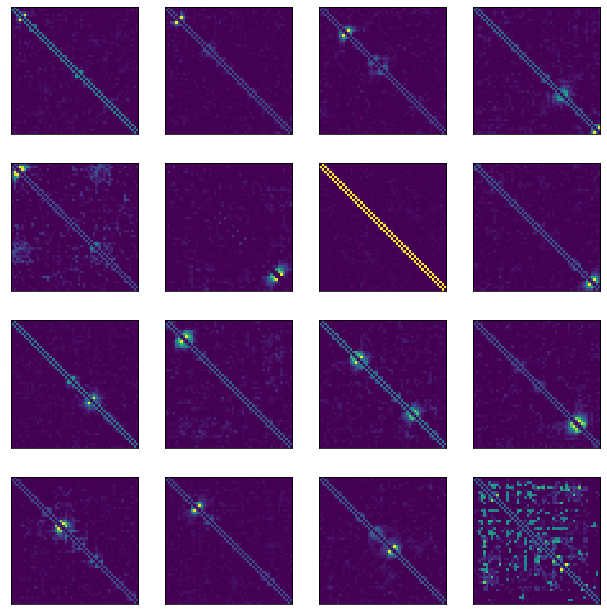

In [9]:
display_dictionary(W = W_true,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_True",
                   figsize = [10,10])

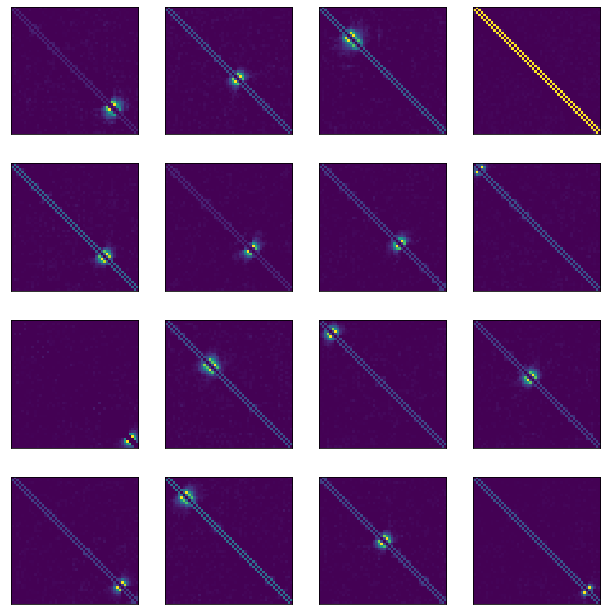

In [10]:
display_dictionary(W = W_false,
                   save_name = save_folder + ntwk_nonumber + "_Dictionary_False",
                   figsize = [10,10])

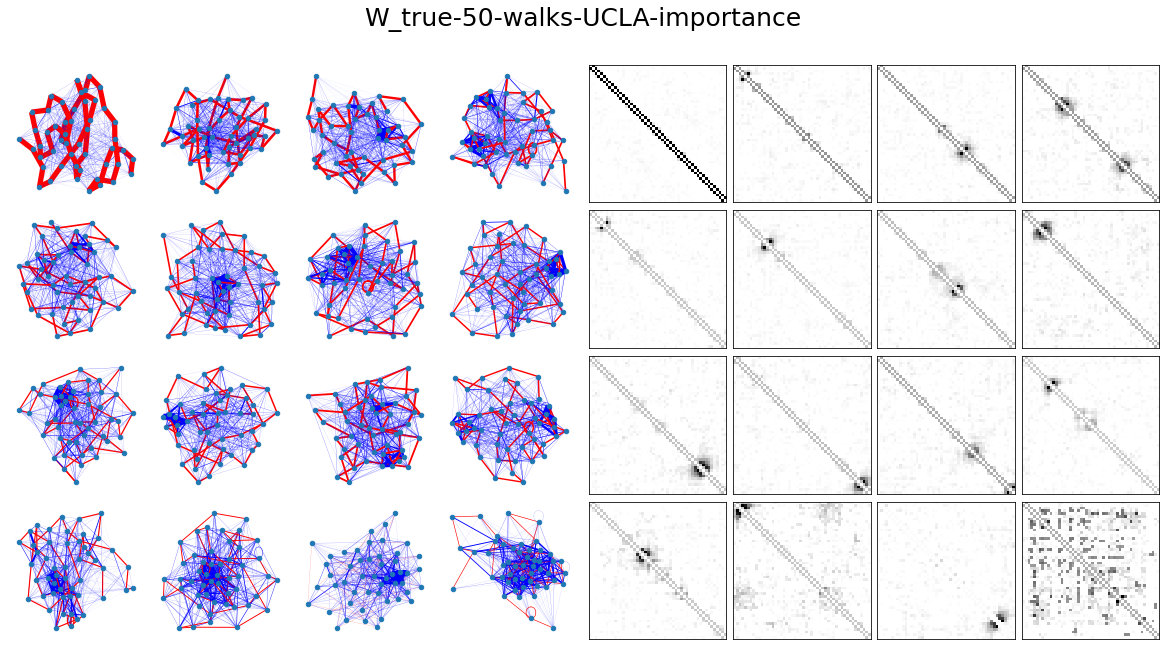

In [11]:
display_dict_and_graph(title='W_true-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_True",
                       W=W_true, 
                       At = np.dot(H_true, H_true.T), 
                       fig_size=[20,10], 
                       show_importance=True)

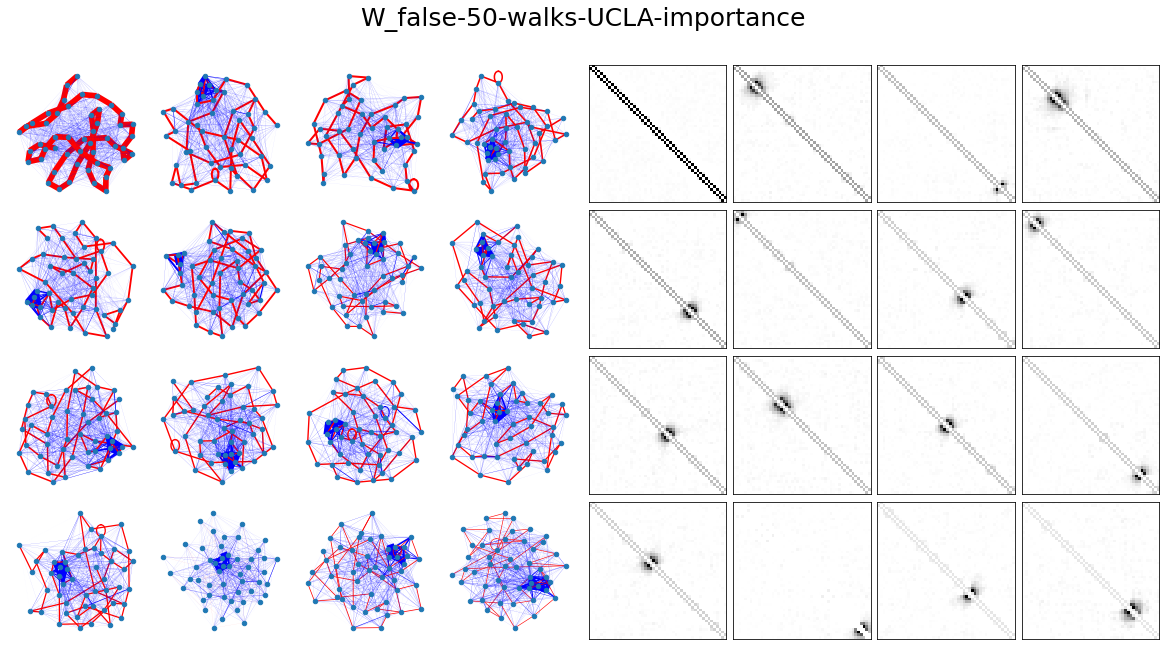

In [12]:
display_dict_and_graph(title='W_false-{}-walks-{}-importance'.format(k, ntwk_nonumber),
                       save_path=save_folder + ntwk_nonumber + "_Dictionary+Graphs_False",
                       W=W_false, 
                       At = np.dot(H_false, H_false.T), 
                       fig_size=[20,10], 
                       show_importance=True)

In [13]:
X = df.drop(['Synchronized'], axis=1).values
Y = df['Synchronized'].values.reshape(-1,1)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, 
                                                    test_size = 0.25,
                                                    stratify = Y)

In [14]:
# SDL_BCD_feature
data_scale=10
results_dict_list = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                X_test = [X_test.T/data_scale, Y_test.T],
                                n_components = r,
                                xi = xi,
                                L1_reg = [0,0,0],
                                L2_reg = [0,0,0],
                                nonnegativity = [True,True,False],
                                full_dim = False)

        results_dict_new = SDL_BCD_class.fit(option = "feature",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[-0.86605518 -0.99011778  0.613712   -0.70681294 -0.2786166  -0.01191786
   0.74710569 -0.90935722  0.06242586 -0.49518227  0.01589325  0.67648256
   0.45282694 -0.32944603 -0.20650618  0.7617932   0.21568981]]


  0%|▏                                          | 1/200 [00:00<00:32,  6.12it/s]

--- Training --- [threshold, AUC] =  [0.255, 0.572]
--- Iteration 0: Training loss --- [Data, Label, Total] = [685.587860.3, 1074.073827.3, 1074.073827.3]


  5%|██                                        | 10/200 [00:00<00:13, 13.87it/s]


--- Training --- [threshold, AUC] =  [0.072, 0.625]
--- Iteration 10: Training loss --- [Data, Label, Total] = [929.148269.3, 1384.383927.3, 1384.383927.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.57027208  0.87198228  0.56089557 -0.17117112  0.564969   -0.82345051
  -0.59780511 -0.33130332  0.26506    -0.20322368 -0.59410109  0.3290184
   0.90683963  0.58649129  0.73799815 -0.6727821   0.33708328]]


  0%|▏                                          | 1/200 [00:00<00:24,  8.16it/s]

--- Training --- [threshold, AUC] =  [0.333, 0.429]
--- Iteration 0: Training loss --- [Data, Label, Total] = [700.411663.3, 1097.575865.3, 1097.575865.3]


  5%|██                                        | 10/200 [00:00<00:13, 13.86it/s]


--- Training --- [threshold, AUC] =  [0.807, 0.494]
--- Iteration 10: Training loss --- [Data, Label, Total] = [963.718750.3, 2384.940789.3, 2384.940789.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.98051142 -0.68950334  0.17463415 -0.22241454  0.69820767 -0.25771459
  -0.69066601  0.33421417  0.19682126 -0.7829918   0.74959144 -0.32831605
  -0.44293195  0.86441478  0.99285618  0.99680791  0.35897212]]


  0%|▏                                          | 1/200 [00:00<00:29,  6.64it/s]

--- Training --- [threshold, AUC] =  [0.16, 0.572]
--- Iteration 0: Training loss --- [Data, Label, Total] = [649.626001.3, 1134.938678.3, 1199.901278.3]


  5%|██                                        | 10/200 [00:00<00:14, 13.16it/s]


--- Training --- [threshold, AUC] =  [0.0, 0.619]
--- Iteration 10: Training loss --- [Data, Label, Total] = [842.563522.3, 5741.374407.3, 5825.630759.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.76278835  0.46268105  0.84875069 -0.93850122  0.4390669   0.66309551
  -0.28239719 -0.11992869  0.87522621 -0.29752217  0.43206812  0.84963333
  -0.75684758 -0.28827276 -0.34299054  0.252575   -0.78139304]]


  2%|▊                                          | 4/200 [00:00<00:13, 14.93it/s]

--- Training --- [threshold, AUC] =  [0.243, 0.573]
--- Iteration 0: Training loss --- [Data, Label, Total] = [704.741686.3, 1075.288048.3, 1145.762217.3]


  5%|██                                        | 10/200 [00:00<00:11, 15.87it/s]


--- Training --- [threshold, AUC] =  [0.057, 0.632]
--- Iteration 10: Training loss --- [Data, Label, Total] = [896.440801.3, 1479.254459.3, 1568.898539.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.2268288   0.35053952 -0.84888061 -0.23163602  0.65905137  0.74681614
   0.1277896   0.12534411  0.14340126 -0.87200656  0.09598933  0.97053705
  -0.88521657  0.94390689 -0.91273057 -0.89650957 -0.30663207]]


  2%|▋                                          | 3/200 [00:00<00:14, 14.04it/s]

--- Training --- [threshold, AUC] =  [0.275, 0.572]
--- Iteration 0: Training loss --- [Data, Label, Total] = [634.133481.3, 1075.013003.3, 1709.146484.3]


  5%|██                                        | 10/200 [00:00<00:12, 15.51it/s]


--- Training --- [threshold, AUC] =  [0.835, 0.605]
--- Iteration 10: Training loss --- [Data, Label, Total] = [512.446965.3, 2587.659788.3, 3100.106753.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.88799289 -0.9341444  -0.79832596 -0.47800307  0.74717329 -0.09864171
  -0.73726919 -0.60546768 -0.89934274  0.97379199 -0.91050369 -0.86224901
   0.28110911 -0.60039903  0.03825233  0.20482224  0.65478795]]


  0%|▏                                          | 1/200 [00:00<00:20,  9.77it/s]

--- Training --- [threshold, AUC] =  [0.269, 0.429]
--- Iteration 0: Training loss --- [Data, Label, Total] = [654.804873.3, 1074.381355.3, 1729.186228.3]


  5%|██                                        | 10/200 [00:00<00:12, 15.41it/s]


--- Training --- [threshold, AUC] =  [0.025, 0.744]
--- Iteration 10: Training loss --- [Data, Label, Total] = [519.930039.3, 1837.376502.3, 2357.306541.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.52852871  0.6374322  -0.88325032  0.66848814 -0.32085697 -0.24054171
   0.13615308  0.17530105  0.88101976  0.39348803  0.99037689 -0.91071952
   0.53526013 -0.99844538  0.05638998 -0.43744997  0.89335058]]


  0%|▏                                          | 1/200 [00:00<00:20,  9.86it/s]

--- Training --- [threshold, AUC] =  [0.216, 0.571]
--- Iteration 0: Training loss --- [Data, Label, Total] = [596.479947.3, 1084.281474.3, 4066.681211.3]


  5%|██                                        | 10/200 [00:00<00:11, 16.83it/s]


--- Training --- [threshold, AUC] =  [0.0, 0.58]
--- Iteration 10: Training loss --- [Data, Label, Total] = [270.427772.3, 4100.205357.3, 5452.344220.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[ 0.68366545  0.33618875 -0.53707547 -0.88998323 -0.73286952 -0.8258821
   0.29220615 -0.72426279  0.17548617  0.99365612 -0.75149479 -0.84418819
  -0.6017135   0.60649492 -0.72275924  0.9764482  -0.66946206]]


  0%|▏                                          | 1/200 [00:00<00:20,  9.68it/s]

--- Training --- [threshold, AUC] =  [0.485, 0.428]
--- Iteration 0: Training loss --- [Data, Label, Total] = [570.248861.3, 1274.006958.3, 4125.251265.3]


  5%|██                                        | 10/200 [00:00<00:18, 10.36it/s]


--- Training --- [threshold, AUC] =  [1.0, 0.453]
--- Iteration 10: Training loss --- [Data, Label, Total] = [246.350581.3, 11136.813923.3, 12368.566829.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.26765978 -0.21158565 -0.37958559 -0.20435329  0.69697903  0.01859124
  -0.66709788 -0.35296563  0.04802772 -0.13769498 -0.10900349  0.13673273
   0.95377616 -0.87328321 -0.37896131 -0.17402973  0.01422816]]


  2%|█                                          | 5/200 [00:00<00:08, 22.64it/s]

--- Training --- [threshold, AUC] =  [0.23, 0.429]
--- Iteration 0: Training loss --- [Data, Label, Total] = [568.697958.3, 1078.639013.3, 6765.618591.3]


  5%|██                                        | 10/200 [00:00<00:09, 19.99it/s]


--- Training --- [threshold, AUC] =  [0.0, 0.582]
--- Iteration 10: Training loss --- [Data, Label, Total] = [252.365303.3, 6059.461889.3, 8583.114923.3]
Early stopping: training loss increased
!!! pred_type naive
initial loading beta [[-0.36536315  0.87516641  0.83139293  0.9363248   0.89257624 -0.17968439
  -0.60164779 -0.39179949  0.11587986  0.02231112  0.91641131 -0.0762518
  -0.98868461 -0.30275918 -0.92441858 -0.52041712 -0.75264409]]


  1%|▍                                          | 2/200 [00:00<00:12, 15.63it/s]

--- Training --- [threshold, AUC] =  [0.301, 0.428]
--- Iteration 0: Training loss --- [Data, Label, Total] = [575.657573.3, 1081.848222.3, 6838.423956.3]


  6%|██▎                                       | 11/200 [00:00<00:09, 20.66it/s]

--- Training --- [threshold, AUC] =  [0.06, 0.584]
--- Iteration 10: Training loss --- [Data, Label, Total] = [238.008337.3, 1456.390553.3, 3836.473926.3]


 12%|████▊                                     | 23/200 [00:01<00:09, 18.85it/s]

--- Training --- [threshold, AUC] =  [0.315, 0.604]
--- Iteration 20: Training loss --- [Data, Label, Total] = [160.697187.3, 1087.562394.3, 2694.534269.3]


 18%|███████▎                                  | 35/200 [00:01<00:07, 22.39it/s]

--- Training --- [threshold, AUC] =  [0.469, 0.597]
--- Iteration 30: Training loss --- [Data, Label, Total] = [51.802669.3, 1247.280428.3, 1765.307114.3]


 22%|█████████▏                                | 44/200 [00:02<00:06, 22.69it/s]

--- Training --- [threshold, AUC] =  [0.45, 0.7]
--- Iteration 40: Training loss --- [Data, Label, Total] = [2.461713.3, 1218.506940.3, 1243.124072.3]


 28%|███████████▊                              | 56/200 [00:02<00:06, 23.70it/s]

--- Training --- [threshold, AUC] =  [0.399, 0.775]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.496327.3, 1153.701922.3, 1158.665190.3]


 32%|█████████████▋                            | 65/200 [00:03<00:05, 23.50it/s]

--- Training --- [threshold, AUC] =  [0.358, 0.781]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.461482.3, 1115.470061.3, 1120.084879.3]


 37%|███████████████▌                          | 74/200 [00:03<00:05, 21.93it/s]

--- Training --- [threshold, AUC] =  [0.324, 0.775]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.432933.3, 1092.357686.3, 1096.687015.3]


 43%|██████████████████                        | 86/200 [00:03<00:04, 23.37it/s]

--- Training --- [threshold, AUC] =  [0.296, 0.775]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.430173.3, 1080.045637.3, 1084.347365.3]


 48%|███████████████████▉                      | 95/200 [00:04<00:04, 23.43it/s]

--- Training --- [threshold, AUC] =  [0.272, 0.78]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.429014.3, 1074.659604.3, 1078.949744.3]


 52%|█████████████████████▎                   | 104/200 [00:04<00:04, 23.16it/s]

--- Training --- [threshold, AUC] =  [0.251, 0.782]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.428496.3, 1074.373876.3, 1078.658839.3]


 58%|███████████████████████▊                 | 116/200 [00:05<00:03, 23.85it/s]

--- Training --- [threshold, AUC] =  [0.234, 0.784]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.428266.3, 1077.352530.3, 1081.635187.3]


 62%|█████████████████████████▋               | 125/200 [00:05<00:03, 24.00it/s]

--- Training --- [threshold, AUC] =  [0.218, 0.786]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.428161.3, 1083.312583.3, 1087.594196.3]


 67%|███████████████████████████▍             | 134/200 [00:05<00:02, 23.56it/s]

--- Training --- [threshold, AUC] =  [0.204, 0.786]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.428108.3, 1090.615332.3, 1094.896408.3]


 73%|█████████████████████████████▉           | 146/200 [00:06<00:02, 24.21it/s]

--- Training --- [threshold, AUC] =  [0.191, 0.787]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.428075.3, 1100.583330.3, 1104.864077.3]


 76%|███████████████████████████████▏         | 152/200 [00:06<00:02, 22.57it/s]

--- Training --- [threshold, AUC] =  [0.18, 0.788]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.428053.3, 1110.426820.3, 1114.707351.3]


 82%|█████████████████████████████████▌       | 164/200 [00:07<00:01, 20.98it/s]

--- Training --- [threshold, AUC] =  [0.17, 0.788]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.428038.3, 1121.321660.3, 1125.602037.3]


 86%|███████████████████████████████████▍     | 173/200 [00:07<00:01, 21.55it/s]

--- Training --- [threshold, AUC] =  [0.161, 0.789]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.428025.3, 1132.730314.3, 1137.010562.3]


 92%|█████████████████████████████████████▉   | 185/200 [00:08<00:00, 22.83it/s]

--- Training --- [threshold, AUC] =  [0.154, 0.789]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.428014.3, 1143.200266.3, 1147.480410.3]


 97%|███████████████████████████████████████▊ | 194/200 [00:08<00:00, 23.66it/s]

--- Training --- [threshold, AUC] =  [0.147, 0.79]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.428005.3, 1154.930001.3, 1159.210051.3]


100%|█████████████████████████████████████████| 200/200 [00:08<00:00, 22.48it/s]


!!! pred_type naive


In [15]:
W = results_dict_new['loading'][0]
coeff = results_dict_new['loading'][1][0]
H = results_dict_new['code']

In [16]:
coeff

array([-1.04785023e+00,  9.80930841e-04,  2.45528348e-02,  8.84057832e-04,
        6.57875457e-04,  3.86311772e-04,  2.37156382e-04,  7.36486615e-05,
        1.20608430e-04,  2.95662932e-05,  5.05123530e-05,  1.06026249e-04,
        2.17730905e-05,  3.63213568e-05,  2.96153576e-05,  2.45599634e-04,
        1.46251295e-03])

In [17]:
print('Accuracy: {}'.format(results_dict_new['Accuracy']))
print('Training RRE: {}'.format(results_dict_new['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new['Relative_reconstruction_loss (test)']))

Accuracy: 0.4848
Training RRE: 0.3577680181502692
Testing RRE: 0.599437492085232


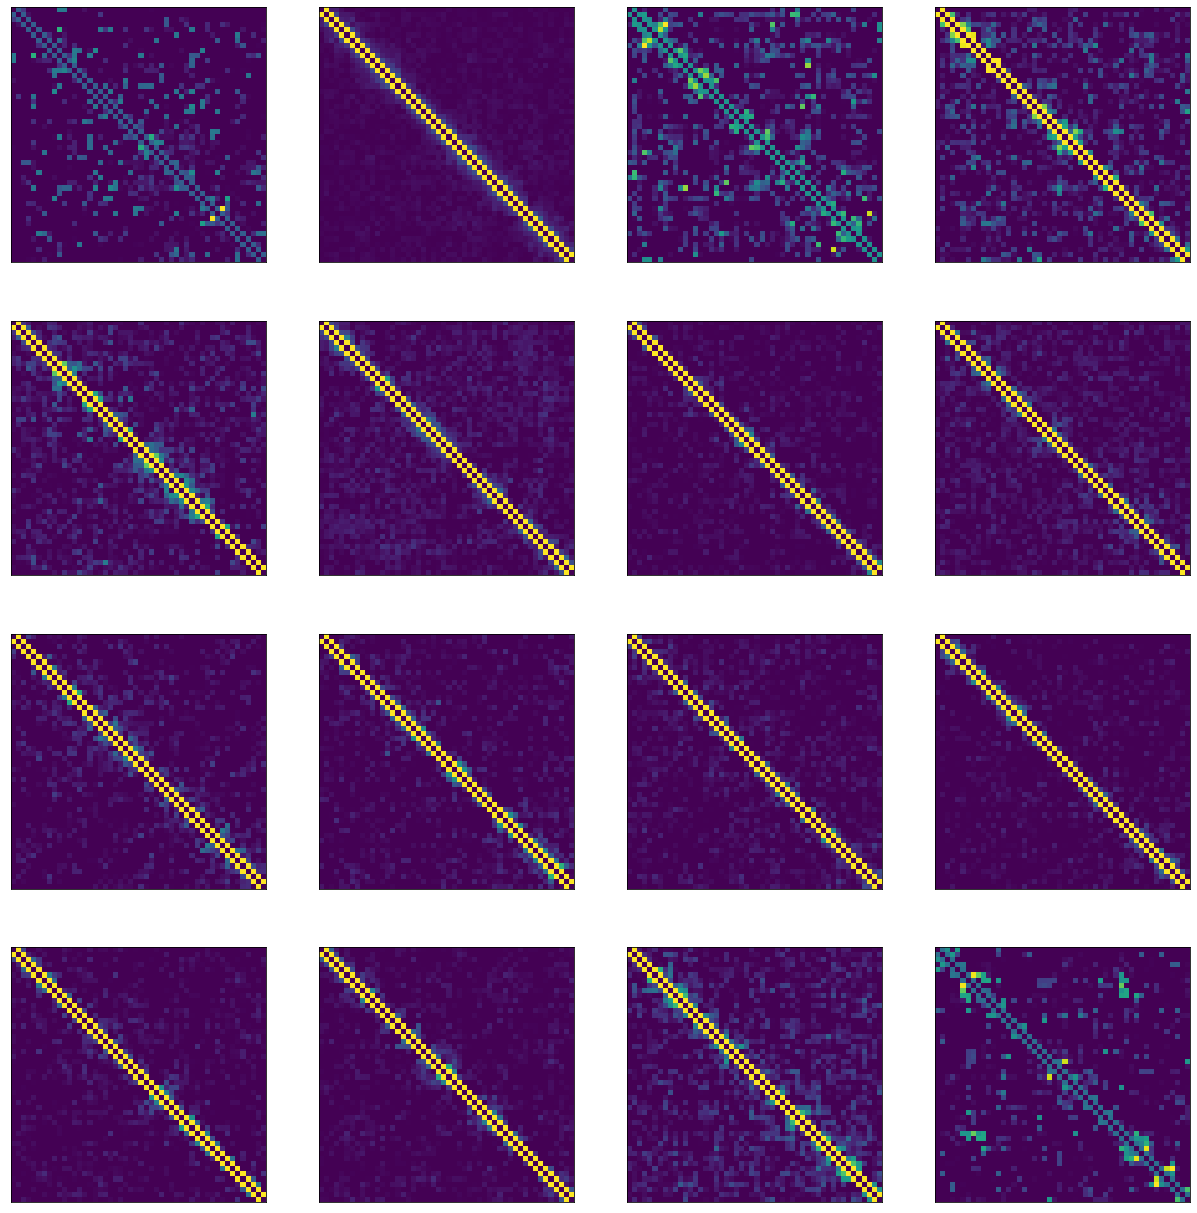

In [18]:
display_dictionary(W = W, figsize=[20,20])

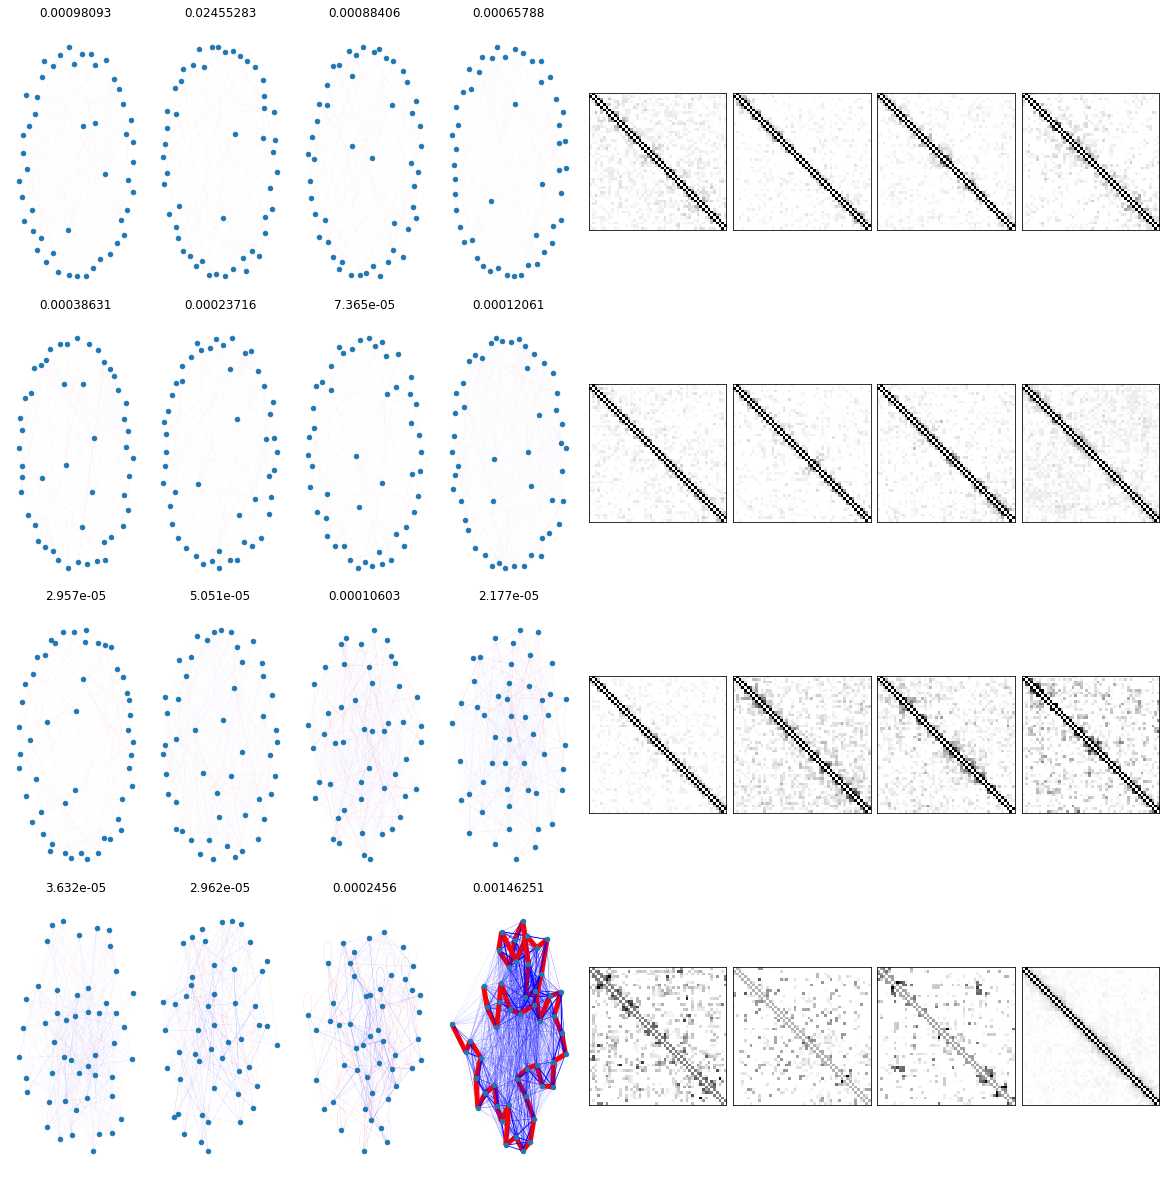

In [19]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 50, 
                       fig_size = [20,20], 
                       show_importance = False)

In [20]:
# SDL_BCD_filter
data_scale=10
results_dict_list_filter = []
iteration1 = 200
r = 16

# Cross-validation
xi_list = [0, 0.1, 1, 5, 10]
beta = 1
iter_avg = 2

for j in range(len(xi_list)):
    xi = xi_list[j]
    for i in range(iter_avg):
        data_scale=500
        SDL_BCD_class_filter = SDL_BCD(X = [X_train.T/data_scale, Y_train.T],
                                       X_test = [X_test.T/data_scale, Y_test.T],
                                       n_components = r,
                                       xi = xi,
                                       L1_reg = [0,0,0],
                                       L2_reg = [0,0,0],
                                       nonnegativity = [True,True,False],
                                       full_dim = False)

        results_dict_new_filter = SDL_BCD_class_filter.fit(option = "filter",
                                             iter = iteration1, 
                                             subsample_size = None,
                                             beta = beta,
                                             update_nuance_param = False,
                                             if_compute_recons_error = True, 
                                             if_validate = False)

initial loading beta [[ 0.79791466 -0.85600767 -0.46085788  0.00607777 -0.40882117 -0.49221579
   0.63259474 -0.73973615  0.18921677 -0.68767076  0.82605496 -0.00535911
   0.68459858 -0.09178399 -0.83429055 -0.23107437  0.97434577]]


  1%|▍                                          | 2/200 [00:00<00:34,  5.68it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.669]
--- Iteration 0: Training loss --- [Data, Label, Total] = [595.909767.3, 1073.931813.3, 1073.931813.3]


  6%|██▌                                       | 12/200 [00:01<00:31,  6.04it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.672]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.854431.3, 1073.930538.3, 1073.930538.3]


 11%|████▌                                     | 22/200 [00:03<00:34,  5.18it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.696]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.184992.3, 1073.918714.3, 1073.918714.3]


 16%|██████▋                                   | 32/200 [00:05<00:30,  5.57it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.74]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.160560.3, 1073.886185.3, 1073.886185.3]


 21%|████████▊                                 | 42/200 [00:07<00:29,  5.40it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.763]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.174789.3, 1073.859998.3, 1073.859998.3]


 26%|██████████▉                               | 52/200 [00:09<00:34,  4.31it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.767]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.182517.3, 1073.853673.3, 1073.853673.3]


 31%|█████████████                             | 62/200 [00:11<00:22,  6.06it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.184925.3, 1073.852898.3, 1073.852898.3]


 36%|███████████████                           | 72/200 [00:13<00:20,  6.20it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.185656.3, 1073.852824.3, 1073.852824.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:18,  6.54it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.185863.3, 1073.852818.3, 1073.852818.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:18,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.185876.3, 1073.852818.3, 1073.852818.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:16,  6.07it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.185877.3, 1073.852818.3, 1073.852818.3]


 56%|██████████████████████▉                  | 112/200 [00:19<00:13,  6.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 61%|█████████████████████████                | 122/200 [00:20<00:13,  5.88it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 66%|██████████████████████████▊              | 131/200 [00:22<00:11,  6.13it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 71%|█████████████████████████████            | 142/200 [00:23<00:10,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:07,  6.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 81%|█████████████████████████████████▏       | 162/200 [00:27<00:07,  4.91it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 86%|███████████████████████████████████▎     | 172/200 [00:28<00:04,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:30<00:02,  6.11it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  5.92it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  6.01it/s]


!!! pred_type filter
initial loading beta [[-0.12188678 -0.96634676 -0.61363615 -0.56259103 -0.52269051  0.25590192
  -0.81046045 -0.73510852 -0.43639576  0.88751901 -0.14635127 -0.17376687
   0.01438583 -0.77395439  0.10662275  0.64369279  0.68385049]]


  1%|▍                                          | 2/200 [00:00<00:35,  5.64it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 0: Training loss --- [Data, Label, Total] = [595.472707.3, 1073.931445.3, 1073.931445.3]


  6%|██▌                                       | 12/200 [00:01<00:32,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.671]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.858918.3, 1073.930161.3, 1073.930161.3]


 11%|████▌                                     | 22/200 [00:03<00:30,  5.89it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.696]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.185378.3, 1073.918328.3, 1073.918328.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.95it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.739]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.160533.3, 1073.886007.3, 1073.886007.3]


 21%|████████▊                                 | 42/200 [00:06<00:25,  6.08it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.762]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.174723.3, 1073.860018.3, 1073.860018.3]


 26%|██████████▉                               | 52/200 [00:08<00:25,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.767]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.182472.3, 1073.853695.3, 1073.853695.3]


 31%|█████████████                             | 62/200 [00:09<00:22,  6.10it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.184905.3, 1073.852902.3, 1073.852902.3]


 36%|███████████████                           | 72/200 [00:11<00:20,  6.17it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.185646.3, 1073.852825.3, 1073.852825.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:20,  5.85it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.185859.3, 1073.852818.3, 1073.852818.3]


 46%|███████████████████▎                      | 92/200 [00:14<00:17,  6.21it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.185876.3, 1073.852818.3, 1073.852818.3]


 51%|████████████████████▉                    | 102/200 [00:16<00:17,  5.62it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.185877.3, 1073.852818.3, 1073.852818.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:15,  5.59it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 61%|█████████████████████████                | 122/200 [00:19<00:14,  5.29it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 66%|███████████████████████████              | 132/200 [00:21<00:12,  5.28it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 70%|████████████████████████████▉            | 141/200 [00:23<00:11,  4.98it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 76%|███████████████████████████████▏         | 152/200 [00:25<00:08,  5.46it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 81%|█████████████████████████████████▏       | 162/200 [00:26<00:06,  5.54it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 86%|███████████████████████████████████▎     | 172/200 [00:28<00:04,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:30<00:03,  5.73it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:31<00:01,  5.60it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.768]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.185878.3, 1073.852818.3, 1073.852818.3]


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  6.01it/s]


!!! pred_type filter
initial loading beta [[ 3.08082625e-02  8.86887096e-01  2.54145172e-01  8.97790680e-01
  -8.70751073e-01 -6.50106523e-01 -7.02220973e-01  5.33296386e-01
   3.14921837e-02  4.49460959e-01 -8.12540874e-04  2.07134105e-01
   8.99984898e-01 -5.40371072e-01 -8.43389847e-01  4.54427244e-01
   5.51577926e-01]]


  1%|▍                                          | 2/200 [00:00<00:38,  5.12it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.669]
--- Iteration 0: Training loss --- [Data, Label, Total] = [622.568684.3, 1073.932998.3, 1136.189866.3]


  6%|██▌                                       | 12/200 [00:02<00:33,  5.54it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.67]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.955940.3, 1073.934405.3, 1074.129999.3]


 10%|████▍                                     | 21/200 [00:03<00:33,  5.31it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.679]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.939826.3, 1073.931180.3, 1074.025162.3]


 16%|██████▋                                   | 32/200 [00:05<00:32,  5.18it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.691]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.605375.3, 1073.926359.3, 1073.986897.3]


 21%|████████▊                                 | 42/200 [00:07<00:31,  5.05it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.702]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.480588.3, 1073.921069.3, 1073.969128.3]


 26%|██████████▉                               | 52/200 [00:09<00:27,  5.44it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.712]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.449805.3, 1073.915323.3, 1073.960304.3]


 31%|█████████████                             | 62/200 [00:11<00:24,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.721]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.439667.3, 1073.909369.3, 1073.953336.3]


 36%|███████████████                           | 72/200 [00:12<00:23,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.728]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.435414.3, 1073.903571.3, 1073.947112.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:21,  5.47it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.734]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.433298.3, 1073.898070.3, 1073.941400.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:19,  5.62it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.739]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.432105.3, 1073.892975.3, 1073.936186.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:18,  5.29it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.744]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.431363.3, 1073.888343.3, 1073.931480.3]


 56%|██████████████████████▉                  | 112/200 [00:19<00:16,  5.30it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.747]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.430868.3, 1073.884194.3, 1073.927280.3]


 61%|█████████████████████████                | 122/200 [00:21<00:14,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.75]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.430517.3, 1073.880527.3, 1073.923579.3]


 66%|███████████████████████████              | 132/200 [00:23<00:12,  5.55it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.753]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.430256.3, 1073.877324.3, 1073.920349.3]


 71%|█████████████████████████████            | 142/200 [00:25<00:10,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.755]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.430054.3, 1073.874542.3, 1073.917547.3]


 76%|███████████████████████████████▏         | 152/200 [00:27<00:09,  4.86it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.757]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.429893.3, 1073.872137.3, 1073.915126.3]


 81%|█████████████████████████████████▏       | 162/200 [00:28<00:07,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.758]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.429761.3, 1073.870061.3, 1073.913037.3]


 86%|███████████████████████████████████▎     | 172/200 [00:30<00:04,  5.60it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.759]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.429649.3, 1073.868272.3, 1073.911237.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:32<00:03,  5.22it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.76]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.429554.3, 1073.866730.3, 1073.909685.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:34<00:01,  5.41it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.761]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.429470.3, 1073.865395.3, 1073.908342.3]


100%|█████████████████████████████████████████| 200/200 [00:35<00:00,  5.57it/s]


!!! pred_type filter
initial loading beta [[-0.9082806  -0.84074966 -0.19663945  0.94812584  0.58545884 -0.01656449
  -0.03365411 -0.73564437 -0.5123016  -0.00607384 -0.1329078   0.38347868
  -0.99926458  0.07348651 -0.29922409  0.23364671  0.14372341]]


  1%|▍                                          | 2/200 [00:00<00:38,  5.08it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 0: Training loss --- [Data, Label, Total] = [625.079694.3, 1073.932648.3, 1136.440617.3]


  6%|██▌                                       | 12/200 [00:02<00:37,  5.00it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.669]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.964536.3, 1073.934066.3, 1074.130520.3]


 11%|████▌                                     | 22/200 [00:04<00:33,  5.24it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.678]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.949112.3, 1073.930748.3, 1074.025659.3]


 16%|██████▋                                   | 32/200 [00:05<00:31,  5.25it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.691]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.610110.3, 1073.925626.3, 1073.986637.3]


 21%|████████▊                                 | 42/200 [00:07<00:30,  5.18it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.703]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.481236.3, 1073.919911.3, 1073.968034.3]


 26%|██████████▉                               | 52/200 [00:09<00:30,  4.86it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.714]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.450923.3, 1073.913674.3, 1073.958767.3]


 31%|█████████████                             | 62/200 [00:11<00:24,  5.73it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.723]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.440947.3, 1073.907237.3, 1073.951332.3]


 36%|███████████████                           | 72/200 [00:13<00:23,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.73]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.436531.3, 1073.901071.3, 1073.944724.3]


 41%|█████████████████▏                        | 82/200 [00:15<00:21,  5.48it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.736]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.434257.3, 1073.895315.3, 1073.938741.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:21,  5.02it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.741]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.432972.3, 1073.890071.3, 1073.933368.3]


 50%|████████████████████▋                    | 101/200 [00:19<00:25,  3.89it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.746]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.432194.3, 1073.885397.3, 1073.928616.3]


 56%|██████████████████████▉                  | 112/200 [00:21<00:19,  4.53it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.749]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.431701.3, 1073.881298.3, 1073.924468.3]


 61%|█████████████████████████                | 122/200 [00:23<00:16,  4.84it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.752]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.431368.3, 1073.877758.3, 1073.920895.3]


 66%|███████████████████████████              | 132/200 [00:25<00:13,  4.93it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.754]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.431122.3, 1073.874728.3, 1073.917840.3]


 71%|█████████████████████████████            | 142/200 [00:27<00:11,  5.06it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.756]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.430925.3, 1073.872147.3, 1073.915240.3]


 76%|███████████████████████████████▏         | 152/200 [00:29<00:09,  4.93it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.758]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.430758.3, 1073.869953.3, 1073.913029.3]


 81%|█████████████████████████████████▏       | 162/200 [00:31<00:07,  5.00it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.759]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.430609.3, 1073.868087.3, 1073.911148.3]


 86%|███████████████████████████████████▎     | 172/200 [00:33<00:05,  5.08it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.76]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.430474.3, 1073.866493.3, 1073.909540.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:35<00:03,  5.06it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.761]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.430348.3, 1073.865127.3, 1073.908161.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:37<00:01,  4.80it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.762]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.430229.3, 1073.863955.3, 1073.906978.3]


100%|█████████████████████████████████████████| 200/200 [00:38<00:00,  5.16it/s]


!!! pred_type filter
initial loading beta [[-0.10305447  0.75559484 -0.84255098  0.47073691 -0.76144905 -0.68931782
   0.32028533 -0.22164381  0.62585697 -0.35989849  0.39484214 -0.13684838
   0.99812116  0.68166699  0.62543975 -0.13674401  0.62298591]]


  1%|▍                                          | 2/200 [00:00<00:39,  5.07it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.669]
--- Iteration 0: Training loss --- [Data, Label, Total] = [780.034744.3, 1073.941385.3, 1853.976129.3]


  6%|██▌                                       | 12/200 [00:02<00:37,  5.04it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.662]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.055993.3, 1073.947030.3, 1076.003024.3]


 10%|████▍                                     | 21/200 [00:04<00:36,  4.87it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.662]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.654651.3, 1073.946712.3, 1074.601363.3]


 16%|██████▋                                   | 32/200 [00:06<00:34,  4.92it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.662]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.516168.3, 1073.946559.3, 1074.462727.3]


 21%|████████▊                                 | 42/200 [00:08<00:30,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.663]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.479051.3, 1073.946435.3, 1074.425486.3]


 26%|██████████▉                               | 52/200 [00:10<00:31,  4.75it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.663]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.462648.3, 1073.946318.3, 1074.408966.3]


 30%|████████████▊                             | 61/200 [00:11<00:27,  5.00it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.664]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.453274.3, 1073.946202.3, 1074.399476.3]


 36%|██████████████▉                           | 71/200 [00:13<00:28,  4.59it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.664]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.447124.3, 1073.946085.3, 1074.393210.3]


 41%|█████████████████▏                        | 82/200 [00:16<00:24,  4.90it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.665]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.442784.3, 1073.945967.3, 1074.388751.3]


 46%|███████████████████                       | 91/200 [00:17<00:21,  4.99it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.665]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.439592.3, 1073.945847.3, 1074.385439.3]


 51%|████████████████████▉                    | 102/200 [00:19<00:18,  5.36it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.666]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.437177.3, 1073.945726.3, 1074.382903.3]


 56%|██████████████████████▉                  | 112/200 [00:21<00:16,  5.34it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.666]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.435315.3, 1073.945603.3, 1074.380918.3]


 61%|█████████████████████████                | 122/200 [00:23<00:14,  5.25it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.667]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.433856.3, 1073.945478.3, 1074.379335.3]


 66%|███████████████████████████              | 132/200 [00:25<00:13,  5.03it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.667]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.432699.3, 1073.945352.3, 1074.378052.3]


 71%|█████████████████████████████            | 142/200 [00:27<00:11,  4.98it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.431771.3, 1073.945225.3, 1074.376996.3]


 76%|███████████████████████████████▏         | 152/200 [00:29<00:09,  5.08it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.431020.3, 1073.945096.3, 1074.376116.3]


 81%|█████████████████████████████████▏       | 162/200 [00:31<00:07,  4.99it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.669]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.430407.3, 1073.944966.3, 1074.375373.3]


 86%|███████████████████████████████████▎     | 172/200 [00:33<00:05,  5.01it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.669]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.429903.3, 1073.944835.3, 1074.374738.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:35<00:03,  4.84it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.67]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.429486.3, 1073.944702.3, 1074.374188.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:37<00:01,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.67]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.429139.3, 1073.944568.3, 1074.373707.3]


100%|█████████████████████████████████████████| 200/200 [00:38<00:00,  5.14it/s]


!!! pred_type filter
initial loading beta [[ 0.31645325 -0.28854506 -0.07056514 -0.11184091  0.35055326  0.46999988
  -0.403806   -0.33713114 -0.1144059   0.4412086  -0.29936646 -0.60630307
   0.5953587  -0.26940482  0.0454317   0.31554901  0.90907562]]


  1%|▍                                          | 2/200 [00:00<00:40,  4.88it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 0: Training loss --- [Data, Label, Total] = [782.465966.3, 1073.941335.3, 1856.407301.3]


  6%|██▌                                       | 12/200 [00:02<00:35,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.667]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.064909.3, 1073.947025.3, 1076.011934.3]


 11%|████▌                                     | 22/200 [00:03<00:32,  5.51it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.667]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.663691.3, 1073.946707.3, 1074.610398.3]


 16%|██████▋                                   | 32/200 [00:05<00:29,  5.76it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.526415.3, 1073.946532.3, 1074.472947.3]


 21%|████████▊                                 | 42/200 [00:07<00:27,  5.80it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.482334.3, 1073.946385.3, 1074.428718.3]


 26%|██████████▉                               | 52/200 [00:08<00:25,  5.76it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.669]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.461097.3, 1073.946243.3, 1074.407340.3]


 31%|█████████████                             | 62/200 [00:10<00:23,  5.87it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.67]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.449041.3, 1073.946100.3, 1074.395141.3]


 36%|███████████████                           | 72/200 [00:12<00:22,  5.57it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.67]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.441666.3, 1073.945954.3, 1074.387620.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:21,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.671]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.436982.3, 1073.945805.3, 1074.382787.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:18,  5.76it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.672]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.433939.3, 1073.945652.3, 1074.379591.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:17,  5.61it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.672]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.431923.3, 1073.945496.3, 1074.377419.3]


 56%|██████████████████████▉                  | 112/200 [00:19<00:15,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.673]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.430567.3, 1073.945338.3, 1074.375904.3]


 61%|█████████████████████████                | 122/200 [00:20<00:14,  5.50it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.673]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.429639.3, 1073.945176.3, 1074.374815.3]


 66%|███████████████████████████              | 132/200 [00:22<00:11,  5.95it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.674]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.428993.3, 1073.945013.3, 1074.374006.3]


 71%|█████████████████████████████            | 142/200 [00:24<00:10,  5.63it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.675]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.428536.3, 1073.944847.3, 1074.373383.3]


 76%|███████████████████████████████▏         | 152/200 [00:26<00:08,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.675]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.428207.3, 1073.944679.3, 1074.372886.3]


 81%|█████████████████████████████████▏       | 162/200 [00:27<00:06,  5.67it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.676]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.427965.3, 1073.944509.3, 1074.372475.3]


 86%|███████████████████████████████████▎     | 172/200 [00:29<00:05,  5.58it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.676]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.427785.3, 1073.944337.3, 1074.372123.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:31<00:03,  5.53it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.677]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.427649.3, 1073.944163.3, 1074.371812.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:32<00:01,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.678]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.427543.3, 1073.943988.3, 1074.371531.3]


100%|█████████████████████████████████████████| 200/200 [00:34<00:00,  5.83it/s]


!!! pred_type filter
initial loading beta [[-0.74892223 -0.56322274 -0.72423077 -0.19652056  0.04777792  0.32827798
   0.67776166 -0.65518653 -0.87717239  0.93865887  0.20328065 -0.58847658
   0.11810647  0.38255678 -0.13725593 -0.79701685  0.52625171]]


  1%|▍                                          | 2/200 [00:00<00:37,  5.32it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.668]
--- Iteration 0: Training loss --- [Data, Label, Total] = [727.538367.3, 1073.953711.3, 4711.645547.3]


  6%|██▌                                       | 12/200 [00:02<00:31,  5.97it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.633]
--- Iteration 10: Training loss --- [Data, Label, Total] = [3.549340.3, 1073.956388.3, 1091.703090.3]


 11%|████▌                                     | 22/200 [00:03<00:32,  5.52it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.585328.3, 1073.956372.3, 1076.883013.3]


 16%|██████▋                                   | 32/200 [00:05<00:33,  4.99it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.469572.3, 1073.956367.3, 1076.304228.3]


 21%|████████▊                                 | 42/200 [00:07<00:26,  6.05it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.453432.3, 1073.956362.3, 1076.223521.3]


 26%|██████████▉                               | 52/200 [00:08<00:24,  5.99it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.449355.3, 1073.956358.3, 1076.203134.3]


 31%|█████████████                             | 62/200 [00:10<00:23,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.447524.3, 1073.956354.3, 1076.193976.3]


 36%|███████████████                           | 72/200 [00:12<00:22,  5.73it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.446296.3, 1073.956349.3, 1076.187827.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:20,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.445314.3, 1073.956345.3, 1076.182913.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:19,  5.65it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.444460.3, 1073.956341.3, 1076.178640.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:16,  5.87it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.443681.3, 1073.956336.3, 1076.174740.3]


 56%|██████████████████████▉                  | 112/200 [00:18<00:15,  5.77it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.442948.3, 1073.956332.3, 1076.171074.3]


 61%|█████████████████████████                | 122/200 [00:20<00:14,  5.50it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.442248.3, 1073.956328.3, 1076.167568.3]


 66%|███████████████████████████              | 132/200 [00:22<00:11,  5.80it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.63]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.441572.3, 1073.956323.3, 1076.164184.3]


 71%|█████████████████████████████            | 142/200 [00:23<00:09,  5.86it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.631]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.440917.3, 1073.956319.3, 1076.160902.3]


 76%|██████████████████████████████▉          | 151/200 [00:25<00:09,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.631]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.440280.3, 1073.956315.3, 1076.157713.3]


 81%|█████████████████████████████████▏       | 162/200 [00:27<00:07,  5.05it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.631]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.439661.3, 1073.956311.3, 1076.154614.3]


 86%|███████████████████████████████████▎     | 172/200 [00:29<00:04,  5.75it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.631]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.439060.3, 1073.956306.3, 1076.151606.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:30<00:03,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.631]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.438478.3, 1073.956302.3, 1076.148691.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:32<00:01,  5.80it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.631]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.437915.3, 1073.956298.3, 1076.145871.3]


100%|█████████████████████████████████████████| 200/200 [00:33<00:00,  5.90it/s]


!!! pred_type filter
initial loading beta [[-0.59119469 -0.23658487 -0.16086938 -0.26525939 -0.73796127  0.08681013
  -0.54552058  0.68181841  0.08658157  0.17414718 -0.49682105 -0.58103877
   0.96649243  0.59198033  0.21912498  0.28035984  0.78937507]]


  1%|▍                                          | 2/200 [00:00<00:37,  5.27it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.67]
--- Iteration 0: Training loss --- [Data, Label, Total] = [730.553596.3, 1073.953532.3, 4726.721511.3]


  6%|██▌                                       | 12/200 [00:02<00:33,  5.67it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.628]
--- Iteration 10: Training loss --- [Data, Label, Total] = [2.861960.3, 1073.956587.3, 1088.266387.3]


 11%|████▌                                     | 22/200 [00:03<00:30,  5.89it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.625]
--- Iteration 20: Training loss --- [Data, Label, Total] = [0.541885.3, 1073.956596.3, 1076.666021.3]


 16%|██████▋                                   | 32/200 [00:05<00:28,  5.98it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.625]
--- Iteration 30: Training loss --- [Data, Label, Total] = [0.462921.3, 1073.956592.3, 1076.271195.3]


 21%|████████▊                                 | 42/200 [00:07<00:27,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.625]
--- Iteration 40: Training loss --- [Data, Label, Total] = [0.452188.3, 1073.956587.3, 1076.217529.3]


 26%|██████████▉                               | 52/200 [00:08<00:25,  5.78it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.625]
--- Iteration 50: Training loss --- [Data, Label, Total] = [0.448996.3, 1073.956583.3, 1076.201563.3]


 31%|█████████████                             | 62/200 [00:10<00:24,  5.70it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.625]
--- Iteration 60: Training loss --- [Data, Label, Total] = [0.447265.3, 1073.956578.3, 1076.192903.3]


 36%|███████████████                           | 72/200 [00:11<00:21,  5.82it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.625]
--- Iteration 70: Training loss --- [Data, Label, Total] = [0.446041.3, 1073.956574.3, 1076.186778.3]


 41%|█████████████████▏                        | 82/200 [00:13<00:20,  5.79it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 80: Training loss --- [Data, Label, Total] = [0.445070.3, 1073.956569.3, 1076.181919.3]


 46%|███████████████████▎                      | 92/200 [00:15<00:19,  5.49it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 90: Training loss --- [Data, Label, Total] = [0.444241.3, 1073.956565.3, 1076.177771.3]


 51%|████████████████████▉                    | 102/200 [00:17<00:20,  4.86it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 100: Training loss --- [Data, Label, Total] = [0.443495.3, 1073.956561.3, 1076.174036.3]


 56%|██████████████████████▉                  | 112/200 [00:19<00:16,  5.29it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 110: Training loss --- [Data, Label, Total] = [0.442800.3, 1073.956556.3, 1076.170555.3]


 61%|█████████████████████████                | 122/200 [00:20<00:14,  5.35it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 120: Training loss --- [Data, Label, Total] = [0.442137.3, 1073.956552.3, 1076.167236.3]


 66%|███████████████████████████              | 132/200 [00:22<00:12,  5.46it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 130: Training loss --- [Data, Label, Total] = [0.441497.3, 1073.956548.3, 1076.164031.3]


 71%|█████████████████████████████            | 142/200 [00:24<00:10,  5.32it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 140: Training loss --- [Data, Label, Total] = [0.440874.3, 1073.956544.3, 1076.160915.3]


 76%|███████████████████████████████▏         | 152/200 [00:26<00:08,  5.39it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 150: Training loss --- [Data, Label, Total] = [0.440268.3, 1073.956539.3, 1076.157877.3]


 81%|█████████████████████████████████▏       | 162/200 [00:28<00:07,  5.12it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 160: Training loss --- [Data, Label, Total] = [0.439676.3, 1073.956535.3, 1076.154914.3]


 86%|███████████████████████████████████▎     | 172/200 [00:30<00:05,  5.52it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 170: Training loss --- [Data, Label, Total] = [0.439098.3, 1073.956531.3, 1076.152020.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:31<00:03,  5.34it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 180: Training loss --- [Data, Label, Total] = [0.438534.3, 1073.956527.3, 1076.149196.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:33<00:01,  5.19it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.626]
--- Iteration 190: Training loss --- [Data, Label, Total] = [0.437985.3, 1073.956522.3, 1076.146445.3]


100%|█████████████████████████████████████████| 200/200 [00:35<00:00,  5.70it/s]


!!! pred_type filter
initial loading beta [[ 0.71718702 -0.9234185  -0.90200569  0.90913633  0.194206    0.29453485
  -0.01885091  0.30074783 -0.85180247 -0.37619564 -0.14889091  0.64297297
   0.97951962 -0.25775542  0.59217072  0.23025883 -0.62423694]]


  1%|▍                                          | 2/200 [00:00<00:40,  4.88it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.473]
--- Iteration 0: Training loss --- [Data, Label, Total] = [377.931005.3, 1073.958389.3, 4853.268439.3]


  6%|██▌                                       | 12/200 [00:02<00:32,  5.71it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.421]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.529456.3, 1073.958389.3, 1089.252951.3]


 11%|████▌                                     | 22/200 [00:03<00:31,  5.58it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.418]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.206297.3, 1073.958389.3, 1086.021357.3]


 16%|██████▋                                   | 32/200 [00:05<00:30,  5.48it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.418]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.191522.3, 1073.958389.3, 1085.873604.3]


 21%|████████▊                                 | 42/200 [00:07<00:30,  5.23it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.418]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.190658.3, 1073.958389.3, 1085.864968.3]


 26%|██████████▉                               | 52/200 [00:09<00:28,  5.26it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.418]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.190508.3, 1073.958389.3, 1085.863472.3]


 31%|█████████████                             | 62/200 [00:10<00:25,  5.41it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.418]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.190386.3, 1073.958389.3, 1085.862249.3]


 36%|███████████████                           | 72/200 [00:12<00:23,  5.43it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.417]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.190258.3, 1073.958389.3, 1085.860974.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:22,  5.33it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.417]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.190133.3, 1073.958389.3, 1085.859720.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:20,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.417]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.189999.3, 1073.958389.3, 1085.858378.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:18,  5.17it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.417]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.189845.3, 1073.958389.3, 1085.856838.3]


 56%|██████████████████████▉                  | 112/200 [00:19<00:16,  5.28it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.417]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.189694.3, 1073.958389.3, 1085.855325.3]


 61%|█████████████████████████                | 122/200 [00:21<00:14,  5.20it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.417]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.189547.3, 1073.958389.3, 1085.853863.3]


 66%|███████████████████████████              | 132/200 [00:23<00:13,  5.08it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.417]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.189400.3, 1073.958389.3, 1085.852386.3]


 71%|█████████████████████████████            | 142/200 [00:25<00:11,  5.02it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.416]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.189243.3, 1073.958389.3, 1085.850823.3]


 76%|███████████████████████████████▏         | 152/200 [00:27<00:08,  5.43it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.416]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.189101.3, 1073.958389.3, 1085.849404.3]


 81%|█████████████████████████████████▏       | 162/200 [00:29<00:07,  5.30it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.416]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.188961.3, 1073.958389.3, 1085.847998.3]


 86%|███████████████████████████████████▎     | 172/200 [00:31<00:05,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.416]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.188809.3, 1073.958389.3, 1085.846481.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:32<00:03,  5.33it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.416]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.188645.3, 1073.958389.3, 1085.844841.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:34<00:01,  5.34it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.416]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.188494.3, 1073.958389.3, 1085.843327.3]


100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.54it/s]


!!! pred_type filter
initial loading beta [[ 0.95230289  0.63185547 -0.26023264 -0.91525862 -0.84270684  0.68728588
  -0.09424782  0.24121726 -0.37243762 -0.63875212  0.47000635 -0.09056939
  -0.93882695 -0.58570732 -0.27801155 -0.20419598  0.10141277]]


  1%|▍                                          | 2/200 [00:00<00:37,  5.25it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.476]
--- Iteration 0: Training loss --- [Data, Label, Total] = [449.771575.3, 1073.958390.3, 5571.674140.3]


  6%|██▌                                       | 12/200 [00:02<00:35,  5.28it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.553]
--- Iteration 10: Training loss --- [Data, Label, Total] = [1.244080.3, 1073.958389.3, 1086.399189.3]


 11%|████▌                                     | 22/200 [00:03<00:33,  5.37it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 20: Training loss --- [Data, Label, Total] = [1.190422.3, 1073.958389.3, 1085.862609.3]


 16%|██████▌                                   | 31/200 [00:05<00:34,  4.96it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.585]
--- Iteration 30: Training loss --- [Data, Label, Total] = [1.190159.3, 1073.958389.3, 1085.859975.3]


 21%|████████▊                                 | 42/200 [00:07<00:28,  5.46it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 40: Training loss --- [Data, Label, Total] = [1.189969.3, 1073.958389.3, 1085.858076.3]


 26%|██████████▉                               | 52/200 [00:09<00:27,  5.44it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.585]
--- Iteration 50: Training loss --- [Data, Label, Total] = [1.189785.3, 1073.958389.3, 1085.856243.3]


 31%|█████████████                             | 62/200 [00:11<00:25,  5.34it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.585]
--- Iteration 60: Training loss --- [Data, Label, Total] = [1.189608.3, 1073.958389.3, 1085.854469.3]


 36%|███████████████                           | 72/200 [00:12<00:23,  5.42it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.585]
--- Iteration 70: Training loss --- [Data, Label, Total] = [1.189410.3, 1073.958389.3, 1085.852487.3]


 41%|█████████████████▏                        | 82/200 [00:14<00:21,  5.42it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.585]
--- Iteration 80: Training loss --- [Data, Label, Total] = [1.189210.3, 1073.958389.3, 1085.850494.3]


 46%|███████████████████▎                      | 92/200 [00:16<00:20,  5.23it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.585]
--- Iteration 90: Training loss --- [Data, Label, Total] = [1.189004.3, 1073.958389.3, 1085.848427.3]


 51%|████████████████████▉                    | 102/200 [00:18<00:20,  4.89it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 100: Training loss --- [Data, Label, Total] = [1.188792.3, 1073.958389.3, 1085.846313.3]


 56%|██████████████████████▉                  | 112/200 [00:20<00:16,  5.44it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 110: Training loss --- [Data, Label, Total] = [1.188562.3, 1073.958389.3, 1085.844006.3]


 61%|█████████████████████████                | 122/200 [00:22<00:15,  5.11it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 120: Training loss --- [Data, Label, Total] = [1.188350.3, 1073.958389.3, 1085.841889.3]


 66%|███████████████████████████              | 132/200 [00:24<00:13,  5.01it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 130: Training loss --- [Data, Label, Total] = [1.188117.3, 1073.958389.3, 1085.839563.3]


 71%|█████████████████████████████            | 142/200 [00:26<00:11,  4.92it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 140: Training loss --- [Data, Label, Total] = [1.187866.3, 1073.958389.3, 1085.837053.3]


 76%|███████████████████████████████▏         | 152/200 [00:27<00:09,  5.12it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.586]
--- Iteration 150: Training loss --- [Data, Label, Total] = [1.187499.3, 1073.958389.3, 1085.833376.3]


 81%|█████████████████████████████████▏       | 162/200 [00:29<00:07,  5.03it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.585]
--- Iteration 160: Training loss --- [Data, Label, Total] = [1.187024.3, 1073.958389.3, 1085.828631.3]


 86%|███████████████████████████████████▎     | 172/200 [00:31<00:05,  5.40it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.584]
--- Iteration 170: Training loss --- [Data, Label, Total] = [1.186559.3, 1073.958389.3, 1085.823976.3]


 91%|█████████████████████████████████████▎   | 182/200 [00:33<00:03,  4.98it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.583]
--- Iteration 180: Training loss --- [Data, Label, Total] = [1.185851.3, 1073.958389.3, 1085.816895.3]


 96%|███████████████████████████████████████▎ | 192/200 [00:35<00:01,  5.27it/s]

--- Training --- [threshold, AUC] =  [0.26, 0.581]
--- Iteration 190: Training loss --- [Data, Label, Total] = [1.185037.3, 1073.958389.3, 1085.808760.3]


100%|█████████████████████████████████████████| 200/200 [00:36<00:00,  5.44it/s]


!!! pred_type filter


In [21]:
W = results_dict_new_filter['loading'][0]
coeff = results_dict_new_filter['loading'][1][0]
H = results_dict_new_filter['code']

In [22]:
coeff

array([-1.04735466e+00,  2.46446478e-06, -1.79293241e-04, -1.50495604e-04,
       -1.61073380e-04, -1.47512874e-04, -1.87638926e-04,  2.26366528e-05,
       -1.63563448e-04, -1.34504295e-04, -1.93315432e-04, -1.70558462e-04,
       -1.02293977e-04, -1.66337367e-04, -1.25427936e-04, -1.61998876e-04,
       -8.86056605e-05])

In [23]:
print('Accuracy: {}'.format(results_dict_new_filter['Accuracy']))
print('Training RRE: {}'.format(results_dict_new_filter['Relative_reconstruction_loss (training)']))
print('Testing RRE: {}'.format(results_dict_new_filter['Relative_reconstruction_loss (test)']))

Accuracy: 0.6752
Training RRE: 0.9905686872851263
Testing RRE: 0.9998908334222404


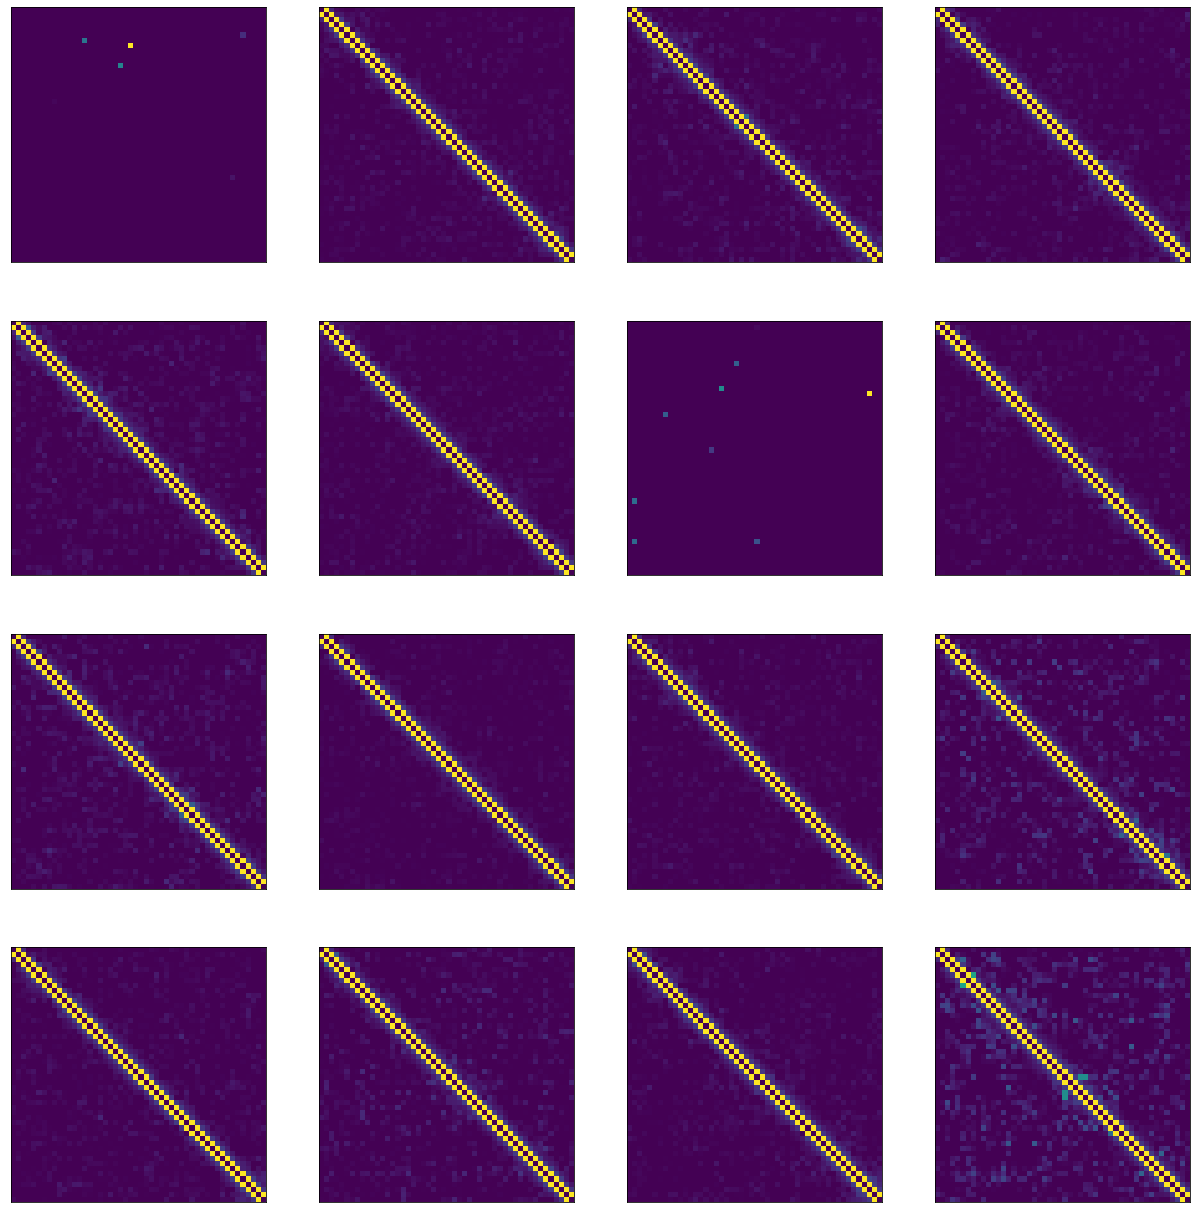

In [24]:
display_dictionary(W = W, figsize=[20,20])

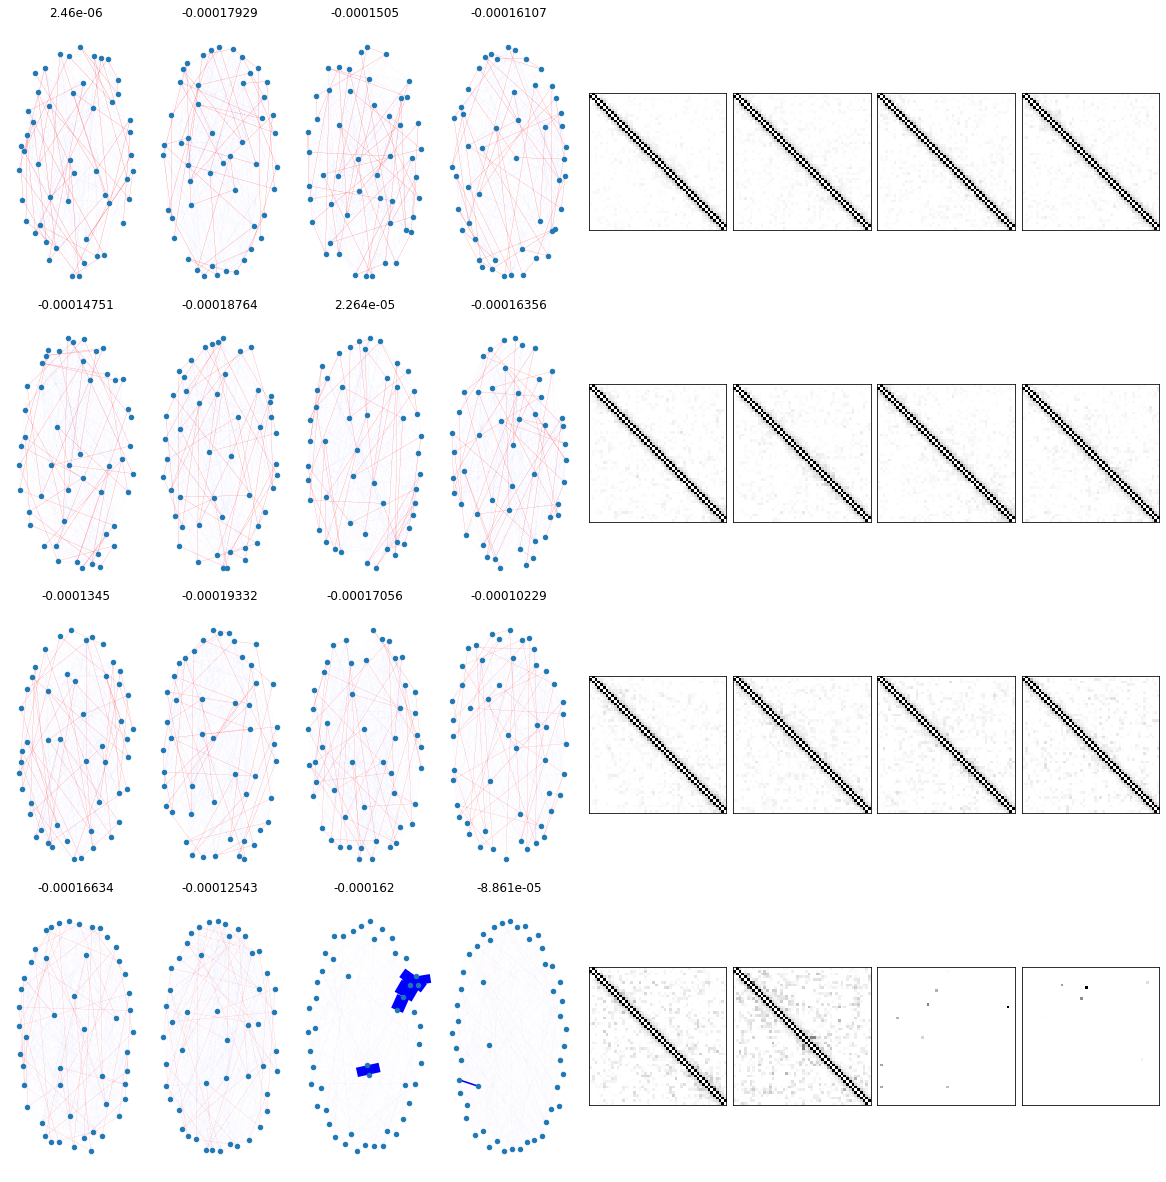

In [25]:
display_dict_and_graph(W = W, 
                       At = np.dot(H, H.T), 
                       regression_coeff = coeff, 
                       weight_graph = 150, 
                       fig_size = [20,20], 
                       show_importance = True)

In [35]:
coeff[np.argsort(coeff)]

array([-1.04735466, -0.00019332, -0.00018764, -0.00017929, -0.00017056,
       -0.00016634, -0.00016356, -0.000162  , -0.00016107, -0.0001505 ,
       -0.00014751, -0.0001345 , -0.00012543, -0.00010229, -0.00008861,
        0.00000246,  0.00002264])

In [32]:
np.set_printoptions(suppress=True)